In [1]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
import pandas as pd
import numpy as np
import re 

train = pd.read_csv("train_merged.csv", low_memory=False)
# pd.set_option('display.max_columns', 500)
test = pd.read_csv("test_merged.csv", low_memory=False)
# targets
act_classes = ['sd', 'b', 'sv', '%', 'fc', 'aa', 'ba', 'qy', 'x', 'ny']

In [2]:
# training processing
train_copy = train.copy()
# use only rows w most freq tags
data = train_copy[train_copy['act_tag'].isin(act_classes)]


In [3]:
# test processing
test_copy = test.copy()
# use only rows w most freq tags
test_data = test_copy[test_copy['act_tag'].isin(act_classes)]

# targets
train_targets = data['act_tag']
test_targets = test_data['act_tag']
y_test = np.array(test_targets)

In [4]:
def text_words(sentence, filter_disfluency=False):
        """
        Tokenized version of the utterance; filter_disfluency=True
        will remove the special utterance notation to make the results
        look more like printed text. The tokenization itself is just
        spitting on whitespace, with no other simplification. The
        return value is a list of str instances.
        """
        t = sentence
        if filter_disfluency:
            t = re.sub(r"([+/\}\[\]]|\{\w)", "", t)
#             t = t.translate(str.maketrans('', '', '?.!-,#'))
            t = t.lower()
        
        return re.split(r"\s+", t.strip())
        

In [5]:
# create new column and fill it based on function, which takes from different column but same row
data['filtered_text']      = data.apply (lambda row: text_words(row['text'], True), axis=1)
test_data['filtered_text'] = test_data.apply (lambda row: text_words(row['text'], True), axis=1)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
def extract_cue_phrases(sen): 
    # initialize binary vector to 0s, set to 1 if condition met 
    feats = [0]* 18
    
    # If utterance length is less than 3 
    if len(sen) <= 3:
        feats[0] = 1
    # If utterance length is longer than 10 
    if len(sen) >= 10: 
        feats[1] = 1
    # Pull out a question
    if '?' in sen:
        feats[2] = 1
    # Uninterpretable
    if '-' in sen:
        feats[3] = 1
    # If sentence starts with a "yes"
    if sen[0] == "yes" :
        feats[4] = 1
    # If sentence starts with a "no"
    if sen[0] == "no":
        feats[5] = 1
    # If sentence starts with a "yeah"
    if sen[0] == "yeah":
        feats[6] = 1    
    # If sentence contains "yes"
    if "yes" in sen:
        feats[7] = 1
    # If sentence contains "no"
    if "no" in sen:
        feats[8] = 1
    # If sentence contains "yeah" -- tends to be uninterpretable
    if "yeah" in sen:
        feats[9] = 1
    # If sentence starts with "do you"
    if sen[0] == "do" and sen[1] == "you":
        feats[10] = 1
    # If sentence starts with "did you"
    if sen[0] == "did" and sen[1] == "you":
        feats[11] = 1
    # Extract statement-opinion
    if "i think" in str(sen):
        feats[12] = 1
    # Agreement
    if "right" == sen[0]:
        feats[13] = 1
    # If sentence starts with "okay"
    if "okay" == sen[0]:
        feats[14] = 1
    # Extract acknowledge
    if "uh-huh" in sen:
        feats[15] = 1
    # Pull out non-verbals 
    if "<" or ">" in sen: 
        feats[16] = 1
    # conventional closing 
    if "well" or "bye" in sen :
        feats[17] = 1


    return feats
    

In [7]:
data['cue_phrases']      = data.apply (lambda row: extract_cue_phrases(row['filtered_text']), axis=1)
test_data['cue_phrases'] = test_data.apply (lambda row: extract_cue_phrases(row['filtered_text']), axis=1)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [8]:
# targets
train_targets = data['act_tag']
# targets
test_targets = test_data['act_tag']
y_test = np.array(test_targets)


In [9]:
# split column of lists into new dataframe
train_df = pd.DataFrame(data.cue_phrases.values.tolist()).add_prefix('feat_')
test_df = pd.DataFrame(test_data.cue_phrases.values.tolist()).add_prefix('feat_')

x_train = np.array(train_df)
y_train = np.array(train_targets)
x_test = np.array(test_df)

scaler = preprocessing.Normalizer()
x_train = scaler.fit_transform(x_train)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 

scaler = preprocessing.RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 


In [10]:
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, 
                    alpha=0.0001, early_stopping=True, 
                    solver='lbfgs', verbose=10,
                    random_state=1,tol=1e-9)

In [11]:
clf.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=1e-09,
       validation_fraction=0.1, verbose=10, warm_start=False)

In [12]:
y_pred = clf.predict(x_test)
print(confusion_matrix(y_test,y_pred))


[[1990    1  357    0    0    0    0   92    0    0]
 [   2    3  775    0    0    9    0   70    0    0]
 [  25    4 6085    0    0   13    0   30    0    0]
 [  11    6  564    0    0    1    0  174    0    0]
 [   4    0  246    0    0    0    0  141    0    0]
 [   0    0  405    0    0    8    0    0    0    0]
 [  23    0   60    0    0    0   99  334    0    0]
 [ 484    0  702    0    0    1    1 9099    0    0]
 [ 154    0  360    0    0    0    0 3638    0    0]
 [   0    0  564    0    0    0    0    5    0    0]]


In [13]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           %       0.74      0.82      0.78      2440
          aa       0.21      0.00      0.01       859
           b       0.60      0.99      0.75      6157
          ba       0.00      0.00      0.00       756
          fc       0.00      0.00      0.00       391
          ny       0.25      0.02      0.04       413
          qy       0.99      0.19      0.32       516
          sd       0.67      0.88      0.76     10287
          sv       0.00      0.00      0.00      4152
           x       0.00      0.00      0.00       569

   micro avg       0.65      0.65      0.65     26540
   macro avg       0.35      0.29      0.26     26540
weighted avg       0.50      0.65      0.55     26540



/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
cm = confusion_matrix(y_test,y_pred)
cm.diagonal()/cm.sum(axis=1)

array([0.81557377, 0.00349243, 0.98830599, 0.        , 0.        ,
       0.01937046, 0.19186047, 0.88451444, 0.        , 0.        ])

In [15]:
accuracy_score(y_test, y_pred)


0.651243406179352

In [16]:
# just the new features 
train_df.to_csv('cue_train.csv')
test_df.to_csv('cue_test.csv')


In [55]:
# index of ? is 2 
train_targets = train_targets.reset_index(drop=True)


In [62]:
feature_set = np.array(train_df)
print(feature_set)

[[0 0 0 ... 0 1 1]
 [0 0 0 ... 0 1 1]
 [1 0 0 ... 0 1 1]
 ...
 [1 0 0 ... 0 1 1]
 [1 0 0 ... 0 1 1]
 [1 0 0 ... 0 1 1]]


In [63]:
from collections import Counter

q_counts = [] 
for i,n in enumerate(feature_set): 
    if n[2] ==1 : 
        q_counts.append(train_targets.iloc[i])

counter = Counter(q_counts)
print(counter)


Counter({'qy': 14, 'fc': 2, 'b': 1, 'sd': 1})


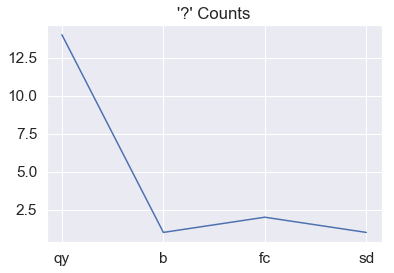

In [64]:
import matplotlib.pyplot as plt 

plt.title("'?' Counts", loc='center')
x = counter.keys()
y = counter.values()
plt.plot(x,y)
plt.show()

CUE PHRASES


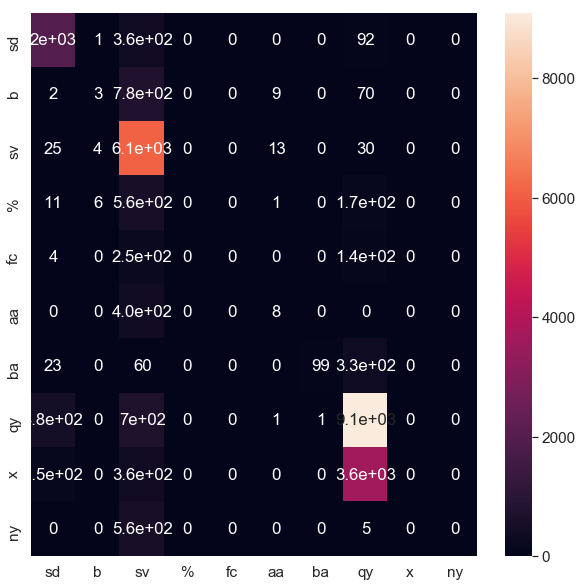

In [42]:
import seaborn as sn
import matplotlib.pyplot as plt

print ("CUE PHRASES")
df_cm = pd.DataFrame(cm, index = [i for i in act_classes],
                  columns = [i for i in act_classes])
plt.figure(figsize = (len(cm[0]),len(cm)))
sn.heatmap(df_cm, annot=True)
